## Data Info

########################################

The ExtraSensory Dataset

Primary data files (features and labels)

########################################

The ExtraSensory Dataset was collected by
Yonatan Vaizman and Katherine Ellis, with the supervision of Gert Lanckriet.
Department of Electrical and Computer Engineering,
University of California, San Diego.

The dataset is publicly available.
Any usage of the dataset for publications requires citing the official paper that introduced the dataset:
Vaizman, Y., Ellis, K., and Lanckriet, G. "Recognizing Detailed Human Context In-the-Wild from Smartphones and Smartwatches".
IEEE Pervasive Computing, vol. 16, no. 4, October-December 2017, pp. 62-74. doi:10.1109/MPRV.2017.3971131
(In the website, we refer to this original paper as Vaizman2017a)

########################################

Content of the primary data files:
There are 60 'csv.gz' files, one for each participant (user, subject) in the data collection.
Each of these files has filename with the form:
[UUID].features_labels.csv.gz
where each user has a unique (randomly generated) universal user identification (UUID) number.
Each file is a textual CSV file, compressed using the gzip format.

Within every user's CSV file:
-----------------------------
- The first row specifies the columns of the file.
- Every other row refers to an example from the user. The examples are sorted according to the primary key - the timestamp.
- The columns:

-- First column is 'timestamp'. This is represented as standard number of seconds since the epoch.

-- Second, come columns for the extracted features.
   Unavailable features are represented with 'nan'.
   The name of each feature contains reference to the sensor it was extracted from, in the form [sensor_name]:[feature_name].
   The current version contains features from the following sensors, with sensor names:
--- raw_acc: Accelerometer from the phone. The 'raw' version of acceleration (as opposed to the decomposed versions of gravity and user-acceleration).   
--- proc_gyro: Gyroscope from the phone. Processed version of gyroscope measurements (the OS calculates a version that removes drift).
--- raw_magnet: Magnetometer from the phone. Raw version (as opposed to bias-fixed version that the OS also provides).
--- watch_acceleration: Accelerometer from the watch.
--- watch_heading: Heading from the compass on the watch.
--- location: Location services. These features were extracted offline for every example from the sequence of latitude-longitude-altitude updates from the example's minute.
              These features regard only to relative-location (not absolute location in the world) - meaning, they describe variability of movement within the minute.
--- location_quick_features: Location services. These features were calculated on the phone when data was collected. 
                             These are available even in cases that the other location features are not because the user wanted to conceal their absolute location coordinates.
							 These quick features are very simple heuristics that approximate the more thoughtful offline features.
--- audio_naive: Microphone. These naive features are simply averages and standard deviations of the 13 MFCCs from the ~20sec recording window of every example.
--- discrete: Phone-state. These are binary indicators for the state of the phone.
              Notice that time_of_day features are also considered phone-state features (also have prefix 'discrete:'), but their columns appear not right after the other 'discrete' columns.
--- lf_measurements: Various sensors that were recorded in low-frequency (meaning, once per example).

-- Third, come columns for the ground truth labels.
   The values are either 1 (label is relevant for the example), 0 (label is not relevant for the example), or 'nan' (label is considered 'missing' for this example).
   Originally, users could only report 'positive' labels (in the original ExtraSensory paper, Vaizman2017a, we assumed that when a label was not reported it is a 'negative' example).
   This cleaned version of the labels has the notion of 'missing labels'; Details about how we inferred missing label information is provided in the second paper, Vaizman2017b (see http://extrasensory.ucsd.edu for updated references).
   The names of the labels have prefix 'label:'. After the prefix:
   If the label name is all capitalized, it is an original label from the mobile app's interface and the values were taken from what the user originally reported.
   If the label name begins with 'FIX_', this is a fixes/cleaned version of a corresponding label, meaning that the researchers fixed some of the values that were reported by users because of inconsistencies.
   If the label name begins with 'OR_', this is a synthesized label, meaning it did not appear in the app's label menu, but rather the researchers created it as combination (using logical or) of other related labels.
   If the label name begins with 'LOC_', this is a fixed/cleaned version of a corresponding label that was fixed by researchers based on absolute location.
      LOC_beach was based on original label 'AT_THE_BEACH'.
	  LOC_home was based on original label 'AT_HOME'.
	  LOC_main_workplace was based on original label 'AT_WORK'.

-- Fourth, the last column is label_source, describing where the original labeling came from in the mobile app's interface. It has 8 possible values:
   -1: The user did not report any labels for this example (notice, however, that this example may still have labeling for the 'LOC_' labels).
   0 : The user used the 'active feedback' interface (reporting immediate future). This example is the first in relevant minute sequence.
   1 : The user used the 'active feedback' interface. This example is a continuation of a sequence of minutes since the user started the reported context.
   2 : The user used the history interface to label an example from the past.
   3 : The user replied to a notification that simply asked to provide any labels.
   4 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'correct' on the phone.
   5 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'not exactly' and then corrected the context labels.
   6 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'correct' on the watch interface.


########################################

## Data Consolidation
Getting the data from all the different files into one csv.

In [15]:
import zipfile
import os
import gzip
import shutil
import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns



In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import load_model, clone_model


import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator


In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [18]:
# Making sure ExtraSensory.per_uuid_features_labels.zip exists and is unziped

def unzip(zip_file):
    # Extract to the directory obtained from the zip file name
    zip_extract_to = zip_file.replace('.zip', '')

    # Unzipping
    if os.path.exists(zip_file):
        if not os.path.exists(zip_extract_to):
            os.makedirs(zip_extract_to)
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(zip_extract_to)
            message = "Unzipped successfully."
        else:
            message = "Directory already exists. File might be unzipped."
    else:
        message = "Zip file not found."

    print(message)
    return zip_extract_to


def csv_extract(zip_extract_to):
    # Improved variable name for the directory where the extracted files will be saved
    unzipped_data_dir = f"{zip_extract_to}-Unzipped"

    # Create the unzipped data directory if it does not exist
    if not os.path.exists(unzipped_data_dir):
        os.makedirs(unzipped_data_dir)

    # Extracting .csv.gz files
    extraction_message = ""
    if os.path.exists(zip_extract_to):
        for file in os.listdir(zip_extract_to):
            if file.endswith('.gz'):
                gz_file_path = os.path.join(zip_extract_to, file)
                csv_file_path = os.path.join(unzipped_data_dir, file[:-3])  # Removing '.gz' from filename

                try:
                    with gzip.open(gz_file_path, 'rb') as f_in:
                        with open(csv_file_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    extraction_message += f"Extracted {file}\n"
                except Exception as e:
                    extraction_message += f"Error extracting {file}: {e}\n"
    else:
        extraction_message = "Directory with .gz files not found."

    print(extraction_message.strip())

    return unzipped_data_dir


# Function to extract user_id from filename
def extract_user_id(filename):
    return filename.split('.')[0]

def make_one_csv(unzipped_data_dir, COMBINED_FILE):
    # Combining all CSVs into one dataframe
    combined_csv_data = pd.DataFrame()

    if os.path.exists(unzipped_data_dir):
        for file in os.listdir(unzipped_data_dir):
            if file.endswith('.csv'):
                file_path = os.path.join(unzipped_data_dir, file)
                user_id = extract_user_id(file)

                # Read the CSV file and add the user_id column
                csv_data = pd.read_csv(file_path)
                csv_data['user_id'] = user_id

                # Append to the combined dataframe
                combined_csv_data = pd.concat([combined_csv_data, csv_data], ignore_index=True)

                
                #print(f"Processed file: {file} \nCurrent size of combined data: {combined_csv_data.shape}")


        # Check if any data has been combined
        if not combined_csv_data.empty:
            # Save the combined CSV data to a file
            combined_csv_data.to_csv(COMBINED_FILE, index=False)
            print(f"Combined CSV file created at {COMBINED_FILE}.")
        else:
            print("No CSV files found to combine or combined data is empty.")
    else:
        print("Directory with unzipped CSV files not found.")
    return COMBINED_FILE



In [19]:
COMBINED_FILE = 'ExtraSensory_Combined_User_Data.csv'
if not os.path.exists(COMBINED_FILE):
    # Path of the zip file
    zip_file = 'ExtraSensory.per_uuid_features_labels.zip'
    zip_extract_to = unzip(zip_file)
    unzipped_data_dir = csv_extract(zip_extract_to)
    make_one_csv(unzipped_data_dir, COMBINED_FILE)
else:
    print('Combined file already exists.')


Combined file already exists.


## Data Exploration

In [20]:
combined_csv_data = pd.read_csv(COMBINED_FILE)
combined_csv_data['timestamp'] = pd.to_datetime(combined_csv_data['timestamp'], unit='s')

In [21]:
print(combined_csv_data.columns)

# user_id is for us to make sure we have record on source of the data. 

Index(['timestamp', 'raw_acc:magnitude_stats:mean',
       'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3',
       'raw_acc:magnitude_stats:moment4',
       'raw_acc:magnitude_stats:percentile25',
       'raw_acc:magnitude_stats:percentile50',
       'raw_acc:magnitude_stats:percentile75',
       'raw_acc:magnitude_stats:value_entropy',
       'raw_acc:magnitude_stats:time_entropy',
       ...
       'label:ELEVATOR', 'label:OR_standing', 'label:AT_SCHOOL',
       'label:PHONE_IN_HAND', 'label:PHONE_IN_BAG', 'label:PHONE_ON_TABLE',
       'label:WITH_CO-WORKERS', 'label:WITH_FRIENDS', 'label_source',
       'user_id'],
      dtype='object', length=279)


In [22]:
# Trying to understand columns
def build_hierarchy(columns):
    # Build a nested dictionary representing the hierarchy of columns.
    hierarchy = {}
    for col in columns:
        parts = col.split(':')
        current_level = hierarchy

        for part in parts[:-1]:
            current_level = current_level.setdefault(part, {})
        
        current_level[parts[-1]] = col

    return hierarchy

def format_hierarchy(hierarchy, indent=0):
    # Format the hierarchy into a readable string with indentation.
    result = ""
    for key, value in hierarchy.items():
        prefix = "  " * indent + "- "
        if isinstance(value, dict):
            result += f"{prefix}{key}:\n{format_hierarchy(value, indent + 1)}"
        else:
            result += f"{prefix} {key}\n"
    return result

# Building and formatting the hierarchy
hierarchy = build_hierarchy(combined_csv_data.columns)
formatted_hierarchy = format_hierarchy(hierarchy)
print(formatted_hierarchy)

-  timestamp
- raw_acc:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  mean_x
    -  mean_y
    -  mean_z
    -  std_x
    -  std_y
    -  std_z
    -  ro_xy
    -  ro_xz
    -  ro_yz
- proc_gyro:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  me

In [23]:
# List of label columns to check
label_columns = [col for col in combined_csv_data.columns if col.startswith("label:")]

combined_csv_data[label_columns] = combined_csv_data[label_columns].fillna(0)

combined_csv_data['label_sum_inital'] = combined_csv_data[label_columns].sum(axis=1)
combined_csv_data['label:UNKNOWN'] = (combined_csv_data['label_sum_inital'] == 0).astype(float)
label_columns.append('label:UNKNOWN')
combined_csv_data = combined_csv_data.drop('label_sum_inital', axis=1)
df = combined_csv_data.copy()


# Function to find the label name with value 1
def find_label_name(row):
    for col in label_columns:
        if row[col] == 1:
            return col.split("label:")[1]
    return None



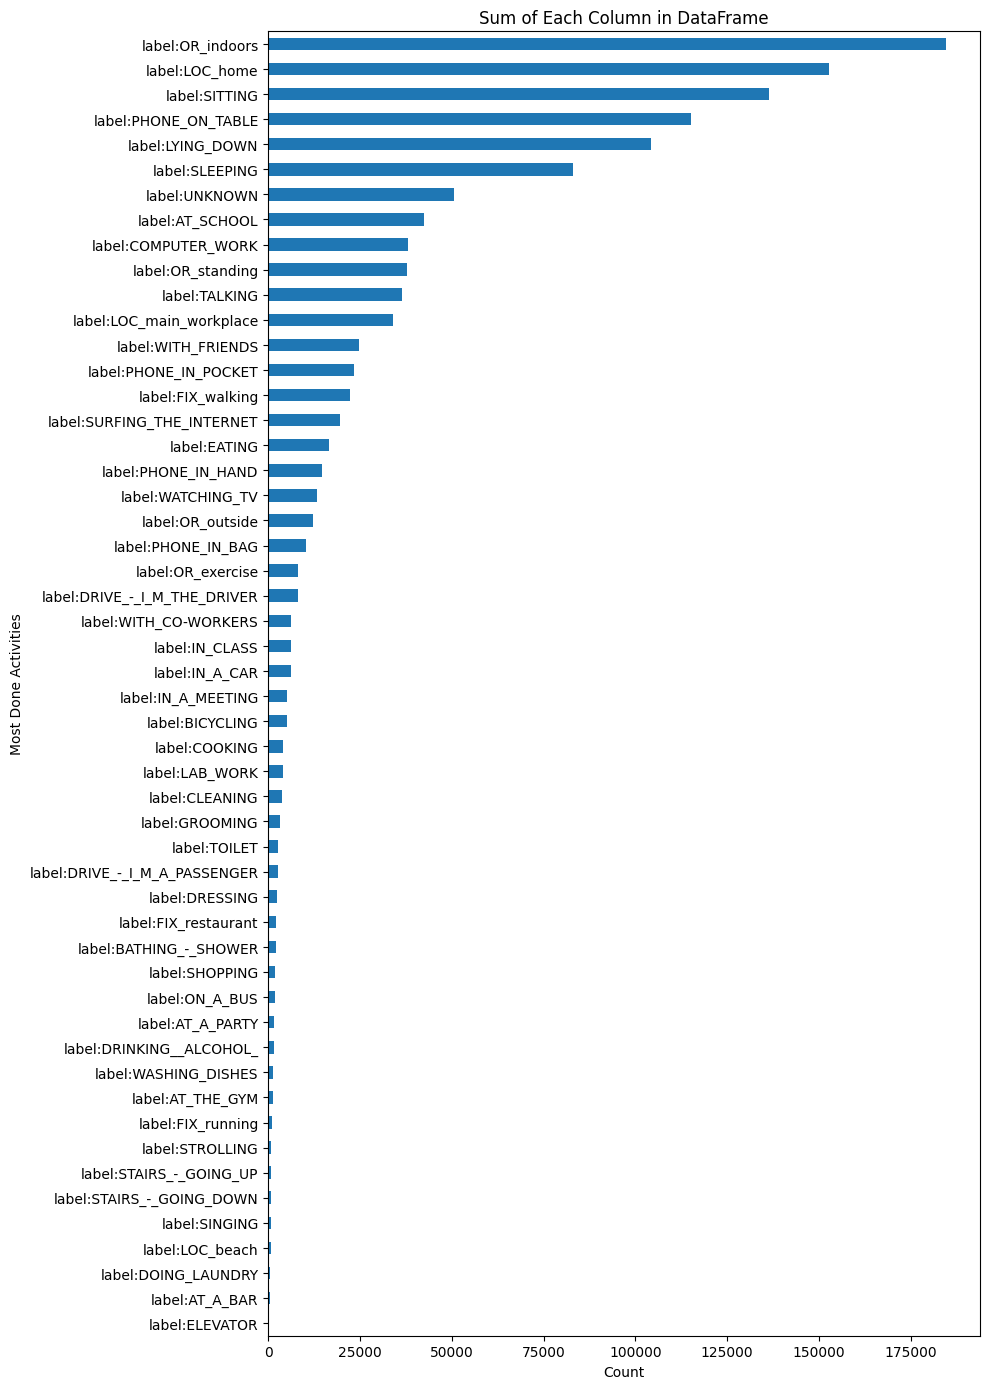

In [24]:
column_sums = df[label_columns].sum()
column_sums_sorted = column_sums.sort_values(ascending=True)

plt.figure(figsize=(10, 14)) 
column_sums_sorted.plot(kind='barh')

# Adding titles and labels for clarity
plt.title('Sum of Each Column in DataFrame')
plt.xlabel('Count')
plt.ylabel('Most Done Activities')

# Adjust layout to make room for the labels
plt.tight_layout()

# Display the plot
plt.show()

In [25]:
# Deleting the other columns
unneeded_columns = ['user_id', 'label_source']
output_columns = [col for col in combined_csv_data.columns if col.startswith('label:')]
input_columns = [col for col in combined_csv_data.columns if col not in output_columns and col not in unneeded_columns]
X_main = df.copy()[input_columns]

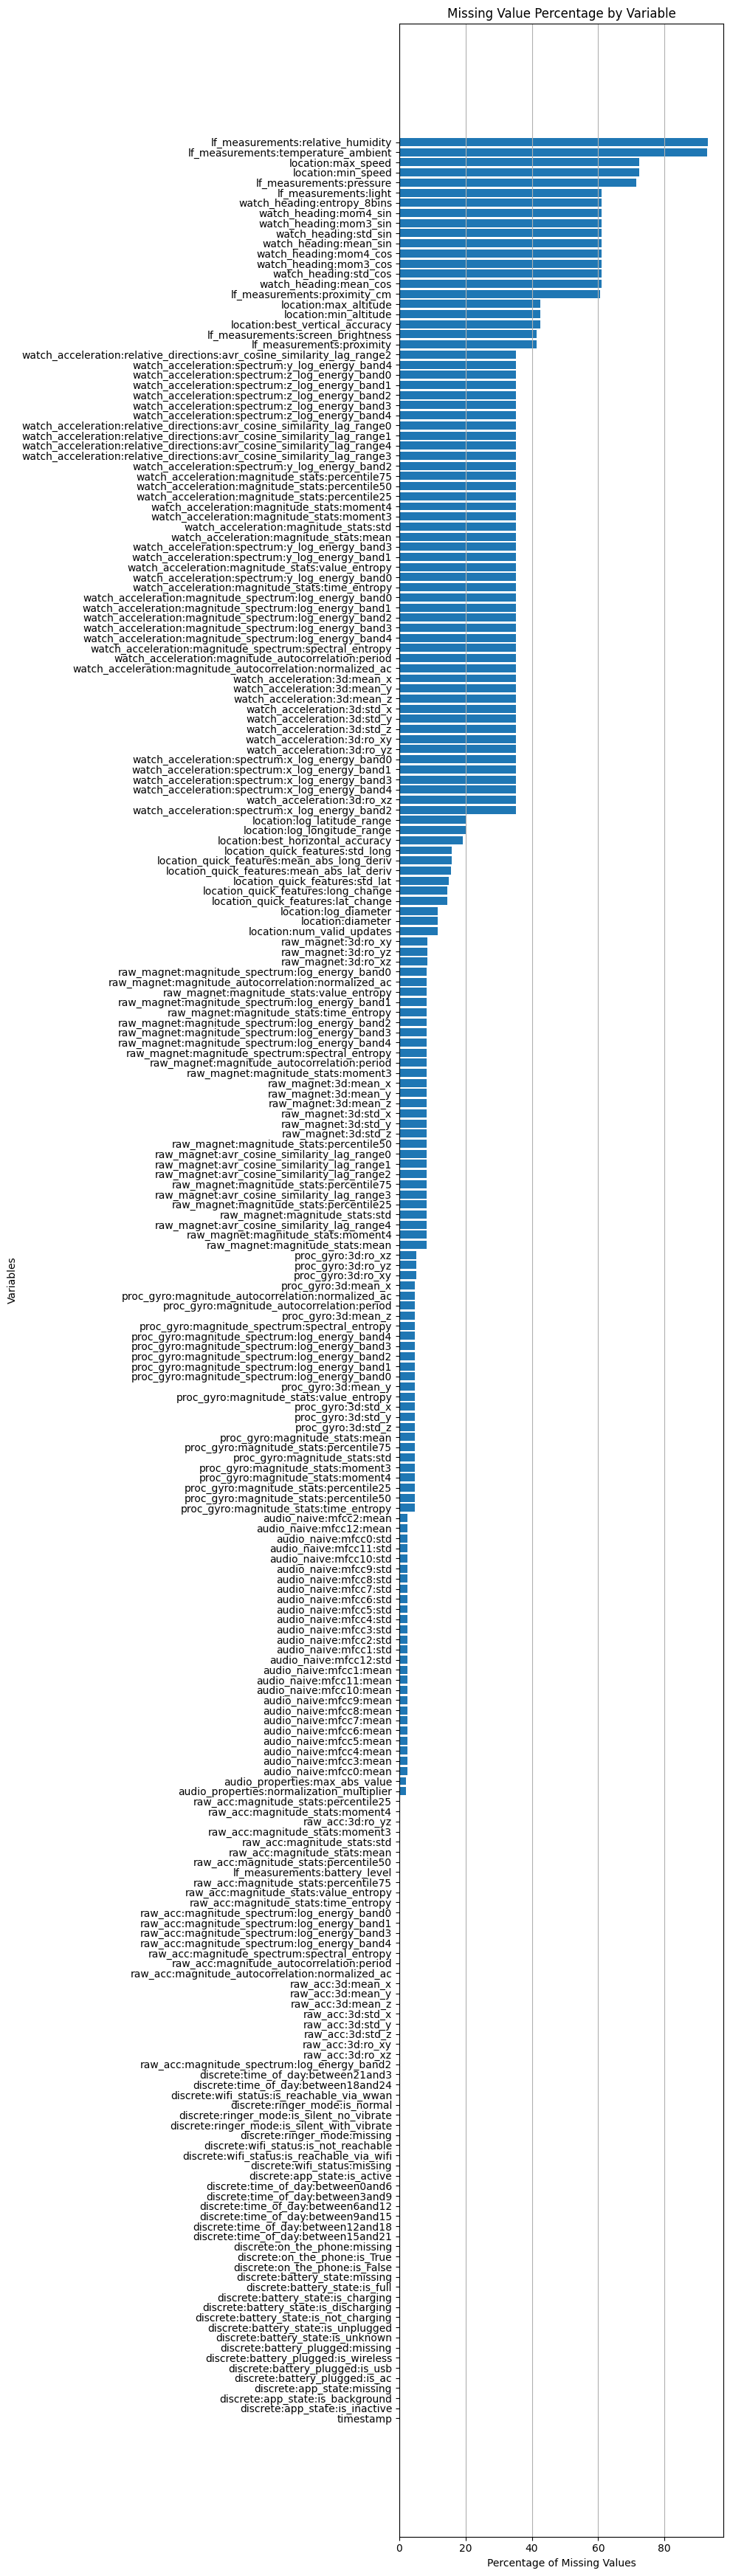

In [26]:
def nan_percentage(df):
    nan_percentage = (df.isna().mean() * 100).round(2)
    nan_percentage_df = pd.DataFrame({'Variable': nan_percentage.index, 'NaN Percentage': nan_percentage.values})
    nan_percentage_df = nan_percentage_df.sort_values(by='NaN Percentage', ascending=True)
    # print(nan_percentage_df)
    
    # Plot setup
    plt.figure(figsize=(10, 35)) 
    plt.barh(nan_percentage_df['Variable'], nan_percentage_df['NaN Percentage'])
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Variables')
    plt.title('Missing Value Percentage by Variable')
    plt.grid(axis='x')

    # Improve readability
    plt.tight_layout()  # Adjust subplot parameters to give specified padding

    plt.show()
    return nan_percentage_df
# Checking overall missing percentage
nan_percentage_df = nan_percentage(X_main)


In [27]:
X_with_users = df.drop(columns=['label_source'])

In [28]:
users = X_with_users['user_id'].unique()
len(users)

60

In [29]:
features = input_columns

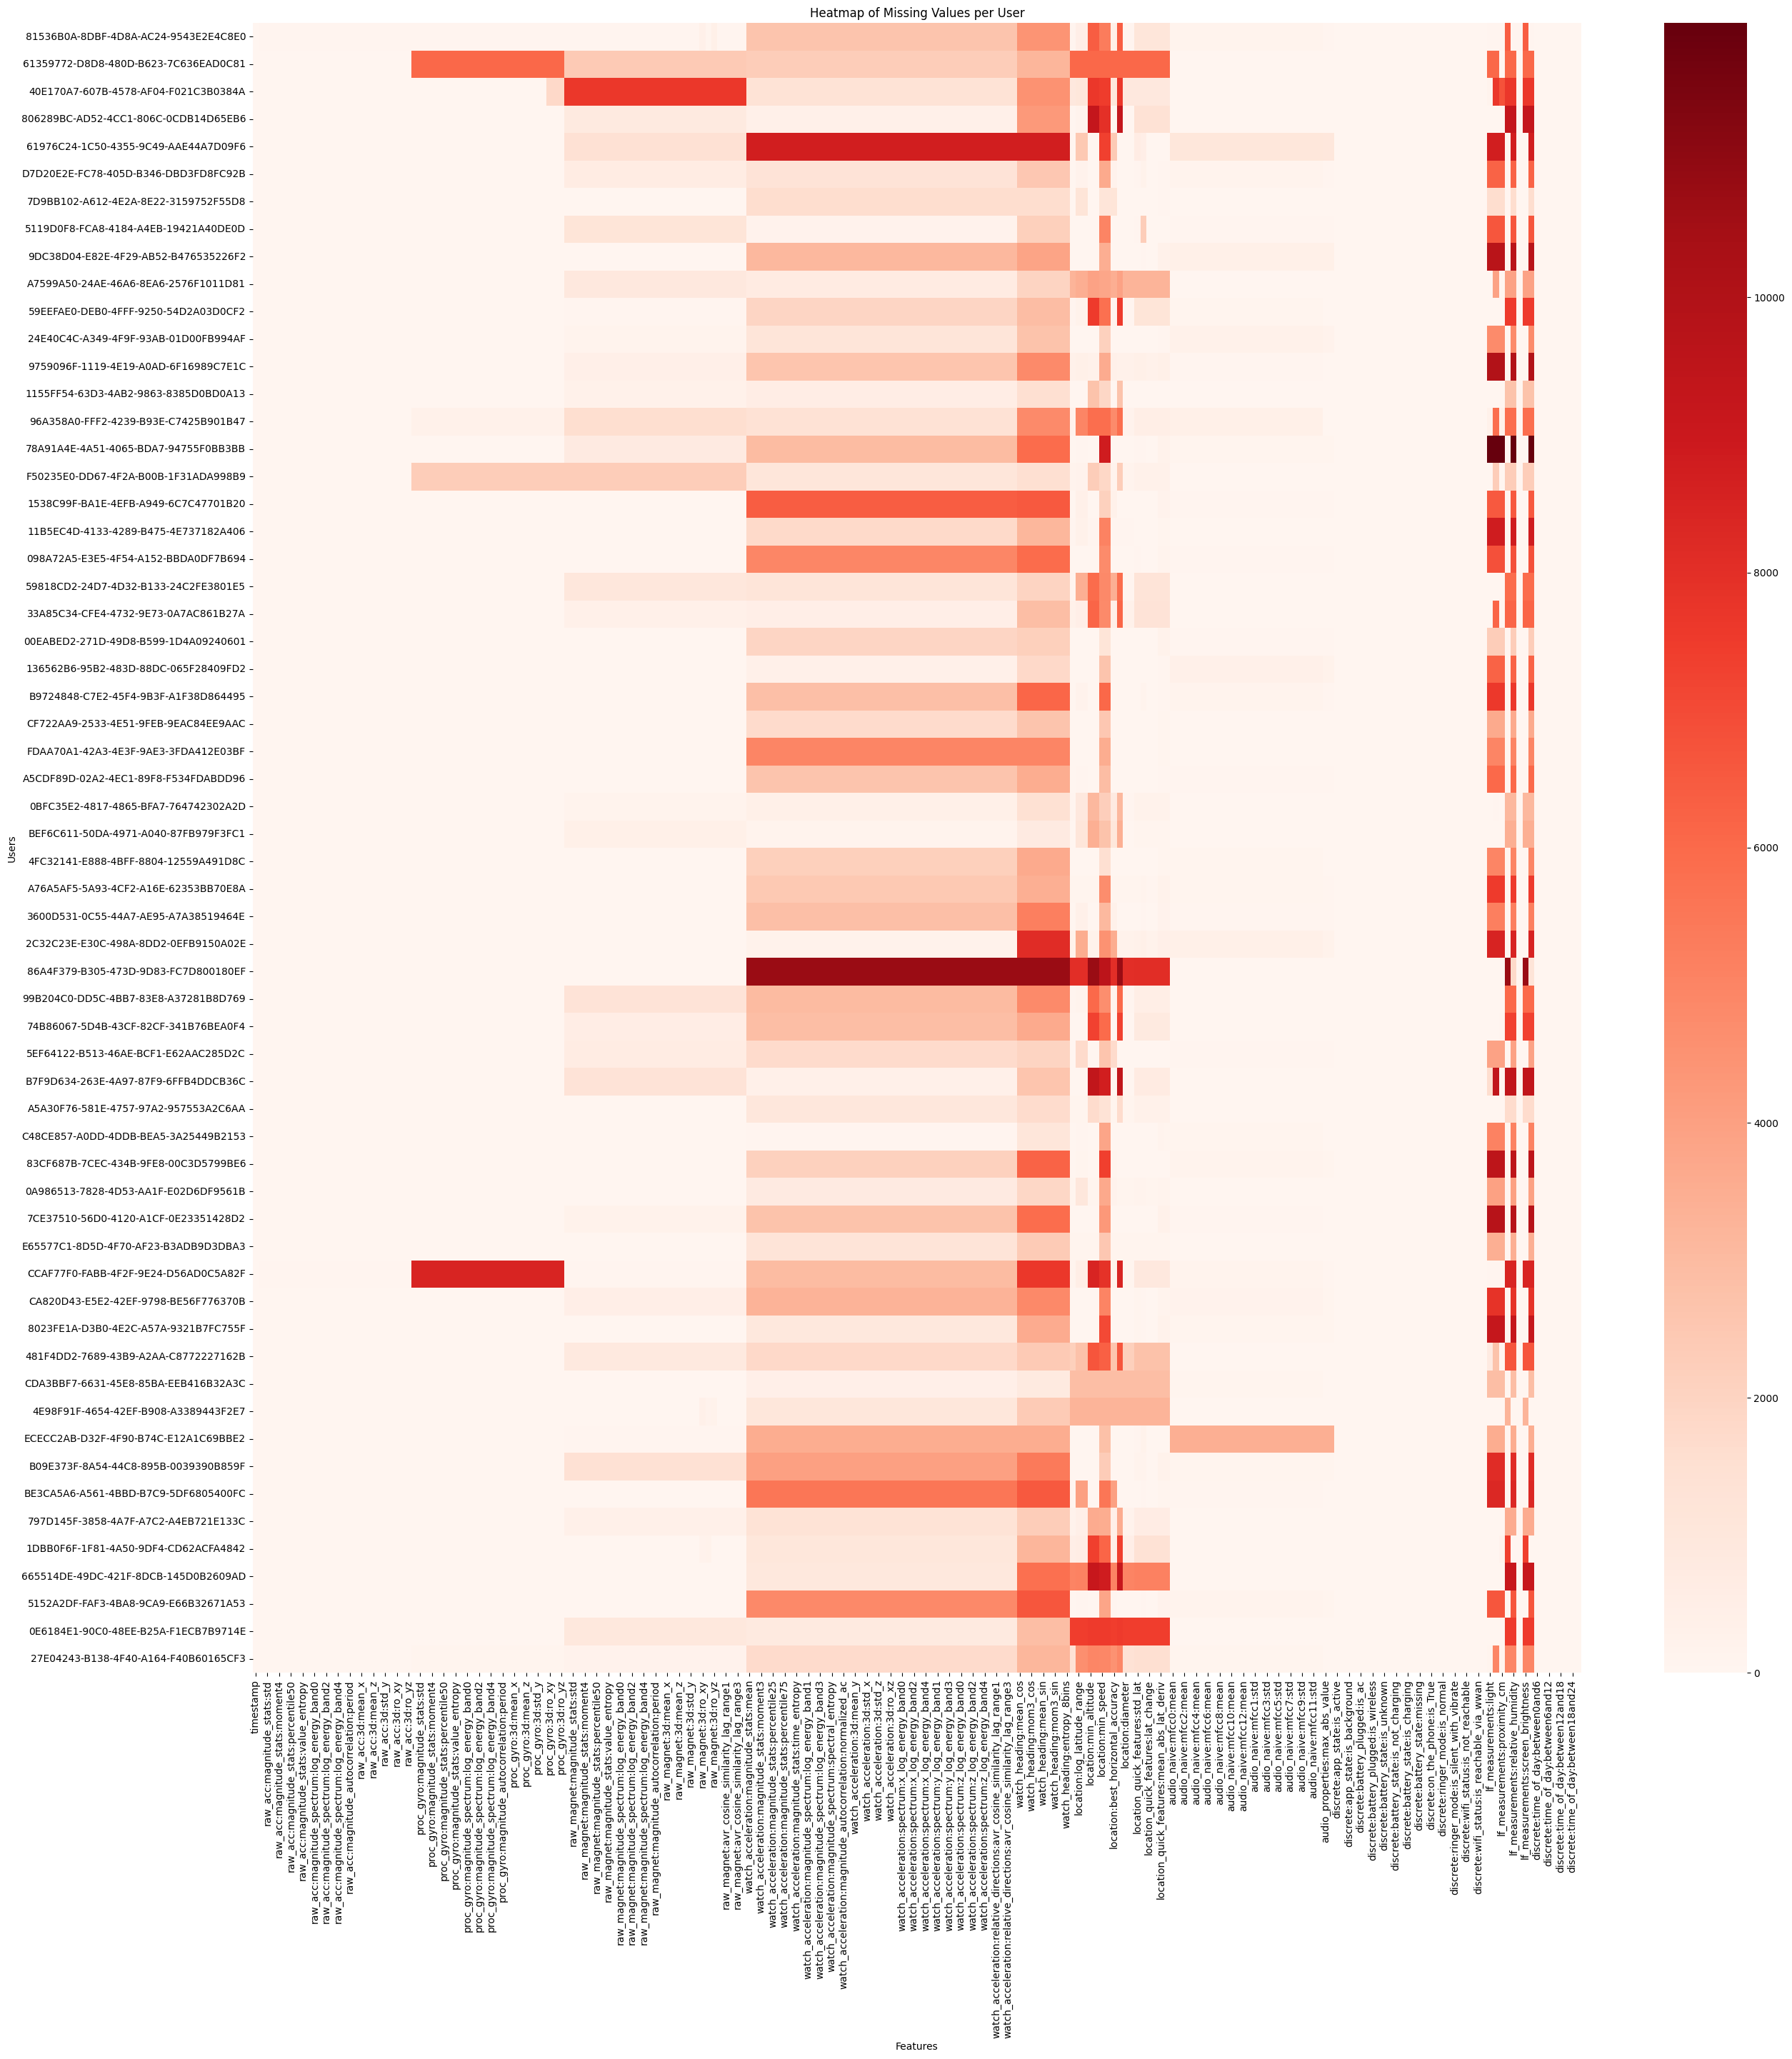

In [30]:
# Initialize a list to store the counts for each user
nan_counts_list = []

# Loop through each user
for user in users:
    # Filter the DataFrame for the current user
    df_user = X_with_users[X_with_users['user_id'] == user]
    
    # Count the NaN values for each feature for the current user and add user_id to the series
    nan_count = df_user[features].isna().sum()
    nan_count['user_id'] = user  # Add user_id to the count
    
    # Append the count series to the list
    nan_counts_list.append(nan_count)

# Convert the list of Series to a DataFrame
nan_counts_per_user = pd.DataFrame(nan_counts_list)

# If needed, set the user_id as the index
nan_counts_per_user.set_index('user_id', inplace=True)


# Plotting the heat map
plt.figure(figsize=(30, 30))
sns.heatmap(nan_counts_per_user, annot=False, cmap='Reds')
plt.title('Heatmap of Missing Values per User')
plt.xlabel('Features')
plt.ylabel('Users')
plt.show()

In [31]:
# Calculate the total number of rows for each user in the original DataFrame
user_total_length = X_with_users.groupby('user_id').size()

# Convert this to a DataFrame or a Series that can be added to nan_counts_per_user
user_total_length_df = user_total_length.to_frame(name='total_length')

# Merge this information with nan_counts_per_user
# Since nan_counts_per_user already has user_id as its index, we can directly add the new column
nan_counts_per_user['total_length'] = user_total_length_df['total_length']

# Now, nan_counts_per_user includes the total_length column


In [32]:

# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100


# Decide on a threshold for removing columns, e.g., 1%
threshold = 0

# Identify columns that exceed this threshold
columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

print("Removing ", len(columns_to_remove),"columns out of ", len(X_with_users.columns))
# Print out the columns to remove
# print("Columns to remove due to excessive missing data:", columns_to_remove)

features_to_include = [feature for feature in features if feature not in columns_to_remove]

if 'timestamp' in X_with_users.columns:
    X_with_users['timestamp_numeric'] = X_with_users['timestamp'].astype(np.int64) // 10**9
    # Ensure 'timestamp_numeric' is included and 'timestamp' is excluded from features_to_include
    features_to_include = [f for f in features_to_include if f != 'timestamp'] + ['timestamp_numeric']

# Continue with your existing preprocessing...
user_df = X_with_users[X_with_users['user_id'] == users[-1]]
median_values = user_df[features_to_include].median()
user_df = user_df[features_to_include].fillna(median_values)


Removing  192 columns out of  279


#### Testing to see if we need to do Binary Relevance, or Classifier chains. We can also check Label Powerset, but the issue is combinations can become very large since we have 52 labels. 

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


combined_csv_data_4_model = combined_csv_data.copy()
combined_csv_data_4_model['timestamp_numeric'] = combined_csv_data_4_model['timestamp'].astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])
# Assuming 'combined_csv_data' is your DataFrame
X = combined_csv_data_4_model[features_to_include]
y = combined_csv_data_4_model[output_columns]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


<Figure size 2000x2000 with 0 Axes>

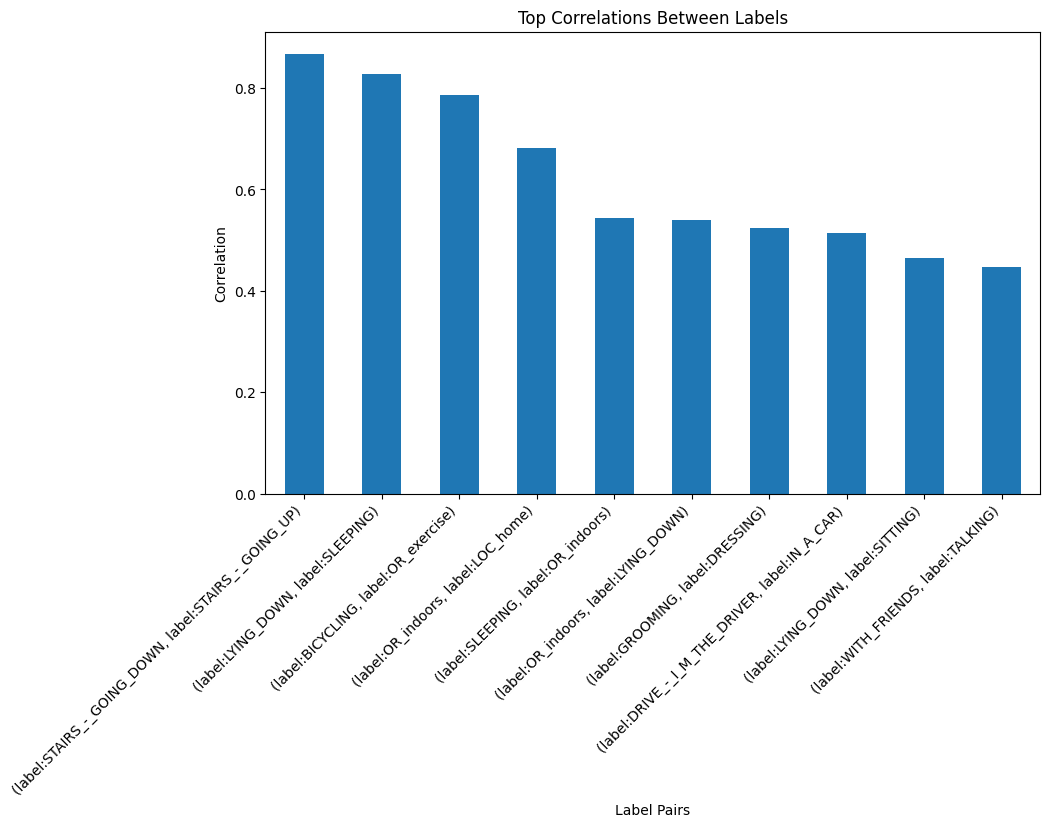

In [20]:
plt.figure(figsize = (20,20))
corr_matrix = y.corr(method = 'pearson')  # Compute the correlation matrix

# Flatten the matrix, sort by absolute value while preserving names
corr_flat = corr_matrix.unstack()
corr_flat_sorted = corr_flat.abs().sort_values(ascending=False)

# Remove self-correlations
corr_flat_sorted = corr_flat_sorted[corr_flat_sorted < 1]

# Take the top N correlations for plotting (for simplicity, let's plot all unique pairs)
unique_pairs = corr_flat_sorted.drop_duplicates().head(10)

# Plotting
plt.figure(figsize=(10, 6))
unique_pairs.plot(kind='bar')
plt.title('Top Correlations Between Labels')
plt.xlabel('Label Pairs')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.show()

Seems like there is a corrolation, lets do Classifier chains. 

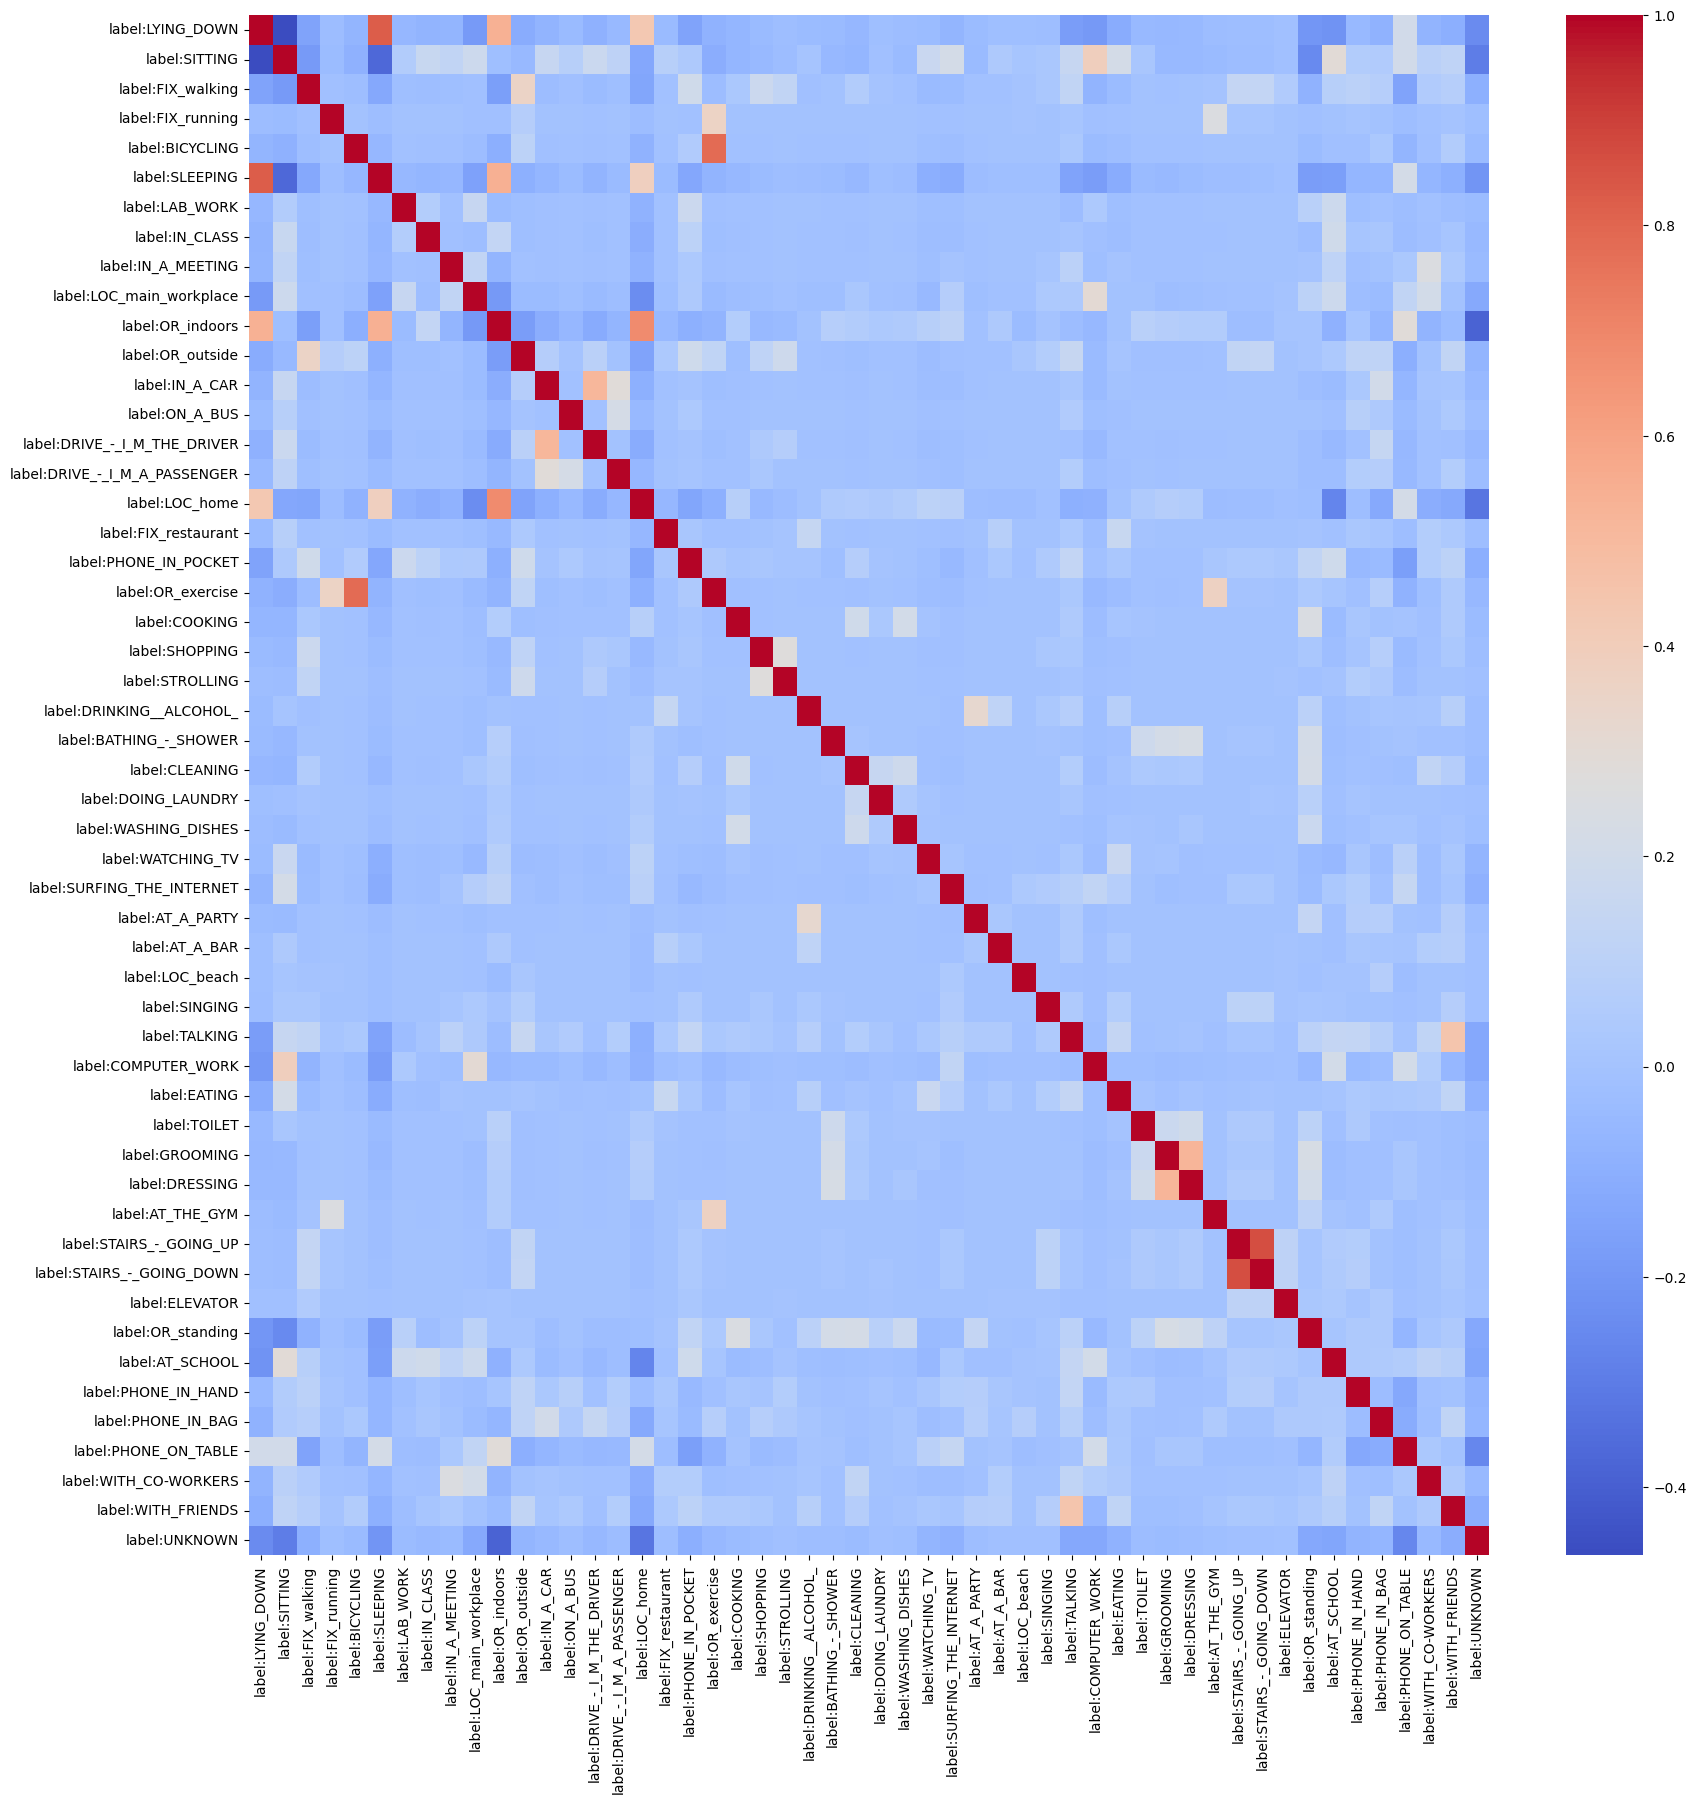

In [21]:
plt.figure(figsize = (20,20))
corr = y.corr(method = 'pearson')
corr_flat = corr.unstack().sort_values(ascending =False)

sns.heatmap(corr, annot = False, cmap = 'coolwarm')
plt.show()

In [22]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [23]:
combined_csv_data.shape

(377346, 280)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


combined_csv_data_4_model = combined_csv_data.iloc[:37734,:].copy()
combined_csv_data_4_model['timestamp_numeric'] = combined_csv_data_4_model['timestamp'].astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])
# Assuming 'combined_csv_data' is your DataFrame
X = combined_csv_data_4_model[features_to_include]
y = combined_csv_data_4_model[output_columns]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [25]:
# Initialize Classifier Chain with a RandomForest base classifier
classifier = ClassifierChain(RandomForestClassifier())

# Train the Classifier Chain model
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate your model
# Example: Using accuracy score, you can choose other metrics as appropriate
from sklearn.metrics import accuracy_score

# Note: accuracy_score expects single-label predictions,
# so for multi-label you might use another metric like hamming loss or a subset accuracy function
# Here's an example with a custom subset accuracy for multi-label
def subset_accuracy(y_true, y_pred):
    return (y_true == y_pred).all(axis=1).mean()

print("Subset Accuracy: ", subset_accuracy(y_test, predictions.toarray()))

Subset Accuracy:  0.956804028090632


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import pickle

user = users[0]

models_data = {
    'models': {},
    'accuracies': {}
}


In [27]:


combined_csv_data_4_model = combined_csv_data.copy()
combined_csv_data_4_model['timestamp_numeric'] = combined_csv_data_4_model['timestamp'].astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])


import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

counter = 1

for user in users:
    
    user_df = combined_csv_data_4_model[combined_csv_data['user_id'] == user]
    
    print(f'Shape of df of user no. {counter} of id {user} is: {user_df.shape}')
    # Assuming 'combined_csv_data' is your DataFrame
    X = user_df[features_to_include]
    y = user_df[output_columns]
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Initialize Classifier Chain with a RandomForest base classifier
    classifier = ClassifierChain(RandomForestClassifier())
    # Train the Classifier Chain model
    classifier.fit(X_train, y_train)
    models_data['models'][user] = classifier
     # Make predictions
    predictions = classifier.predict(X_test)
    # Evaluate your model
    # Example: Using accuracy score, you can choose other metrics as appropriate
    from sklearn.metrics import accuracy_score

    # Note: accuracy_score expects single-label predictions,
    # so for multi-label you might use another metric like hamming loss or a subset accuracy function
    # Here's an example with a custom subset accuracy for multi-label
    def subset_accuracy(y_true, y_pred):
        return (y_true == y_pred).all(axis=1).mean()
    accuracy = subset_accuracy(y_test, predictions.toarray())
    models_data['accuracies'][user] = accuracy
    print(f"Subset Accuracy for {user}: ", accuracy)
    with open('clfs_2.pkl', 'wb') as file:
        pickle.dump(models_data, file)
    print('File Updated')
    counter = counter +1

Shape of df of user no. 1 of id 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0 is: (6407, 280)
Subset Accuracy for 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0:  0.9438377535101404
File Updated
Shape of df of user no. 2 of id 61359772-D8D8-480D-B623-7C636EAD0C81 is: (6079, 280)
Subset Accuracy for 61359772-D8D8-480D-B623-7C636EAD0C81:  0.9769736842105263
File Updated
Shape of df of user no. 3 of id 40E170A7-607B-4578-AF04-F021C3B0384A is: (7649, 280)
Subset Accuracy for 40E170A7-607B-4578-AF04-F021C3B0384A:  0.949673202614379
File Updated
Shape of df of user no. 4 of id 806289BC-AD52-4CC1-806C-0CDB14D65EB6 is: (9242, 280)
Subset Accuracy for 806289BC-AD52-4CC1-806C-0CDB14D65EB6:  0.9497025419145484
File Updated
Shape of df of user no. 5 of id 61976C24-1C50-4355-9C49-AAE44A7D09F6 is: (8730, 280)
Subset Accuracy for 61976C24-1C50-4355-9C49-AAE44A7D09F6:  0.9616265750286369
File Updated
Shape of df of user no. 6 of id D7D20E2E-FC78-405D-B346-DBD3FD8FC92B is: (6210, 280)
Subset Accuracy for D7D20E2E-FC78-40

In [28]:
print(f'Shape of df is: {combined_csv_data_4_model.shape}')
# Assuming 'combined_csv_data' is your DataFrame
X = combined_csv_data_4_model[features_to_include]
y = combined_csv_data_4_model[output_columns]
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize Classifier Chain with a RandomForest base classifier
classifier = ClassifierChain(RandomForestClassifier())
# Train the Classifier Chain model
classifier.fit(X_train, y_train)
models_data['models']["all"] = classifier
    # Make predictions
print('Processing predictions for X_test.')
predictions = classifier.predict(X_test)

def subset_accuracy(y_true, y_pred):
    return (y_true == y_pred).all(axis=1).mean()
print('Processing accuracy.')

accuracy = subset_accuracy(y_test, predictions.toarray())
models_data['accuracies']["all"] = accuracy
print(f"Subset Accuracy for all together data is: ", accuracy)
with open('all_clfs_2.pkl', 'wb') as file:
    pickle.dump(models_data, file)
print('File Updated')


Shape of df is: (377346, 280)
Processing predictions for X_test.
Processing accuracy.
Subset Accuracy for all together data is:  0.7812905790380283
File Updated


Old numbers
Shape of df is: (377346, 280)
Processing predictions for X_test.
Processing accuracy.
Subset Accuracy for all together data is:  0.40275606201139524
File Updated

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import pickle

# Define your MLP model
class MultiTaskMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiTaskMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Placeholder for models and accuracies
models_data_2 = {
    'models': {},
    'accuracies': {}
}

# Loop through each user
for user in users:
    user_df = combined_csv_data_4_model[combined_csv_data_4_model['user_id'] == user]
    X = user_df[features_to_include].values
    y = user_df[output_columns].values
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Initialize the model
    model = MultiTaskMLP(input_size=X_train_tensor.shape[1], output_size=y_train_tensor.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(10):  # Adjust epochs as needed
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.sigmoid(outputs) > 0.5  # Threshold at 0.5
            total += labels.size(0)
            correct += (predicted == labels).float().mean()
    accuracy = correct / total
    
    # Store the model and accuracy
    models_data_2['models'][user] = model.state_dict()  # Store state dict for minimal size
    models_data_2['accuracies'][user] = accuracy.item()
    print(f"User {user}: Accuracy = {accuracy.item():.4f}")

# Save the models and accuracies
with open('mlp_models.pkl', 'wb') as file:
    pickle.dump(models_data_2, file)


User 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0: Accuracy = 0.0161
User 61359772-D8D8-480D-B623-7C636EAD0C81: Accuracy = 0.0152
User 40E170A7-607B-4578-AF04-F021C3B0384A: Accuracy = 0.0154
User 806289BC-AD52-4CC1-806C-0CDB14D65EB6: Accuracy = 0.0151
User 61976C24-1C50-4355-9C49-AAE44A7D09F6: Accuracy = 0.0155
User D7D20E2E-FC78-405D-B346-DBD3FD8FC92B: Accuracy = 0.0156
User 7D9BB102-A612-4E2A-8E22-3159752F55D8: Accuracy = 0.0149
User 5119D0F8-FCA8-4184-A4EB-19421A40DE0D: Accuracy = 0.0154
User 9DC38D04-E82E-4F29-AB52-B476535226F2: Accuracy = 0.0153
User A7599A50-24AE-46A6-8EA6-2576F1011D81: Accuracy = 0.0161
User 59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2: Accuracy = 0.0154
User 24E40C4C-A349-4F9F-93AB-01D00FB994AF: Accuracy = 0.0151
User 9759096F-1119-4E19-A0AD-6F16989C7E1C: Accuracy = 0.0157
User 1155FF54-63D3-4AB2-9863-8385D0BD0A13: Accuracy = 0.0162
User 96A358A0-FFF2-4239-B93E-C7425B901B47: Accuracy = 0.0160
User 78A91A4E-4A51-4065-BDA7-94755F0BB3BB: Accuracy = 0.0156
User F50235E0-DD67-4F2A-

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assuming 'combined_csv_data_4_model', 'features_to_include', and 'output_columns' are defined

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_csv_data_4_model[features_to_include])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, combined_csv_data_4_model[output_columns], test_size=0.2, random_state=42)


# Convert dataset to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.values)  # For multi-label
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values)  # For multi-label


# DataLoader setup
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model setup
model = nn.Sequential(
    nn.Linear(len(features_to_include), 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, len(output_columns))
)

# Loss and optimizer setup
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.train()
for epoch in range(10):  # Number of epochs
    for inputs, labels in train_loader:
        lr = 0.0001 * (epoch + 1)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/10, Loss: {loss.item():.4f}')

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = torch.sigmoid(outputs) > 0.5  # Applying sigmoid and threshold for multi-label
        total += labels.size(0)
        correct += (predicted == labels.byte()).all(dim=1).sum().item()  # Adjust for multi-label accuracy
accuracy = 100 * correct / total

print(f'Accuracy: {accuracy:.2f}%')


Epoch 1/10, Loss: 0.1382
Epoch 2/10, Loss: 0.1561
Epoch 3/10, Loss: 0.1397
Epoch 4/10, Loss: 0.1419
Epoch 5/10, Loss: 0.1252
Epoch 6/10, Loss: 0.1436
Epoch 7/10, Loss: 0.1461
Epoch 8/10, Loss: 0.1591
Epoch 9/10, Loss: 0.1807
Epoch 10/10, Loss: 0.1931
Accuracy: 6.54%


In [72]:
subset_accuracy(y_test, predictions.toarray())

0.6770670826833073

In [63]:
testing_df = pd.DataFrame(predictions.toarray())
testing_df.columns = y_test.columns


In [71]:
print('Predicted    |    Real Value')

cols = y_test.columns
for i in range(1):
    for col in cols:
        print(testing_df.iloc[i][col],  y_test.iloc[i][col])

Predicted    |    Real Value
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


In [55]:
print(predictions.toarray()[1])


[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [51]:
print(predictions)

  (0, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (12, 0)	1.0
  (14, 0)	1.0
  (21, 0)	1.0
  (23, 0)	1.0
  (27, 0)	1.0
  (30, 0)	1.0
  (36, 0)	1.0
  (41, 0)	1.0
  (43, 0)	1.0
  (45, 0)	1.0
  (52, 0)	1.0
  (56, 0)	1.0
  (57, 0)	1.0
  (58, 0)	1.0
  (62, 0)	1.0
  (69, 0)	1.0
  (72, 0)	1.0
  (76, 0)	1.0
  (79, 0)	1.0
  :	:
  (782, 51)	1.0
  (784, 51)	1.0
  (801, 51)	1.0
  (813, 51)	1.0
  (814, 51)	1.0
  (816, 51)	1.0
  (822, 51)	1.0
  (848, 51)	1.0
  (858, 51)	1.0
  (860, 51)	1.0
  (893, 51)	1.0
  (947, 51)	1.0
  (966, 51)	1.0
  (997, 51)	1.0
  (1019, 51)	1.0
  (1032, 51)	1.0
  (1054, 51)	1.0
  (1090, 51)	1.0
  (1115, 51)	1.0
  (1119, 51)	1.0
  (1137, 51)	1.0
  (1147, 51)	1.0
  (1209, 51)	1.0
  (1225, 51)	1.0
  (1242, 51)	1.0


In [46]:
y_true.head()

NameError: name 'y_true' is not defined

In [ ]:

# Scale features
from sklearn.preprocessing import MinMaxScaler

s1 = MinMaxScaler(feature_range=(-1,1))
user_df_scaled = s1.fit_transform(user_df)
user_df_scaled = pd.DataFrame(user_df_scaled, columns=features_to_include)

# Create sequences
look_back = 4
generator = TimeseriesGenerator(user_df_scaled.values, user_df_scaled.values,
                                length=look_back, batch_size=1)
def create_lstm_model(input_shape, num_features):
    model = Sequential([
        LSTM(units = num_features, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        Dense(num_features),
        LSTM(units=num_features, return_sequences=True),
        Dropout(0.2),        
        LSTM(units=num_features, return_sequences=True),
        Dense(num_features),
        Dropout(0.2),
        LSTM(units=num_features, return_sequences=True),
        Dense(num_features),
        Dropout(0.2),        
        LSTM(units=num_features),
        Dense(num_features),
        Activation('linear'),
        
    ])
    model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])  
    return model
model_path = 'LSTM_next_model.h5'
# Define and compile the LSTM model
model = create_lstm_model((look_back, len(features_to_include)), len(features_to_include))

import keras
if os.path.exists(model_path):
    load_model(model_path)
else:

    model.fit(generator, epochs=1) 
    model.save(model_path)

In [57]:
def predict_from_df(df, model, features_to_include, look_back=4):
    df_filtered = df[features_to_include]
    
    if len(df_filtered) >= look_back:
        # Extract the last `look_back` rows for the prediction
        last_sequences = df_filtered[-look_back:].values.reshape((1, look_back, len(features_to_include)))
    else:
        raise ValueError(f"DataFrame must have at least {look_back} rows for prediction.")
    
    # Predict the next row using the LSTM model
    predictions = model.predict(last_sequences)
    
    
    return predictions

def compare_predictions_with_actual(df, model, features_to_include, look_back=3):
    predictions = predict_from_df(user_df.iloc[1:5], model, features_to_include, look_back)
    predictions = s1.inverse_transform(predictions)
    actual_values = user_df.iloc[4][features_to_include].values  # Adjust index if needed
    
    return predictions, actual_values

# Assuming 'user_df' is already preprocessed appropriately, including scaling
predictions, actual_values = compare_predictions_with_actual(user_df, model, features_to_include, look_back=4)

# Now you can compare 'predictions' with 'actual_values'
# Note: If your data was scaled, you might need to inverse scale both predictions and actual values before comparison

print(f"{'Predictions':<15}   | {'Actual Values':<15} | {'Diff':<15} | {'Diff %':<15}")
print("-" * 47)  # Adjust the number based on the width of your columns

j = 0
for i in range(len(predictions[j])):
    p = predictions[j][i]
    a = actual_values[i]
    diff = a-p
    diff_p = ((p-a)/a)*100
    print(f"{p:.6f}{'':<9} | {a:<15} | {diff:.6f} | {diff_p:.6f}")



1/1 [==============================] - 1s 859ms/step
Predictions       | Actual Values   | Diff            | Diff %         
-----------------------------------------------
1.087502          | 0.992139        | -0.095363 | 9.611823
0.321921          | 0.008221        | -0.313700 | 3815.839554
0.173169          | -0.010007       | -0.183176 | -1830.479131
0.445987          | 0.017953        | -0.428034 | 2384.189988
0.838229          | 0.988784        | 0.150555 | -15.226278
1.023328          | 0.992739        | -0.030589 | 3.081304
1.255472          | 0.995041        | -0.260431 | 26.172922
1.498911          | 1.481067        | -0.017844 | 1.204784
6.612895          | 6.684577        | 0.071682 | -1.072342
4.992745          | 5.043079        | 0.050334 | -0.998082
1.474535          | 0.000594        | -1.473941 | 248138.173398
2.362392          | 0.00138         | -2.361012 | 171087.822370
1.889040          | 0.000869        | -1.888171 | 217280.896811
2.147585          | 0.013867     

/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_93077/1789851892.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  diff_p = ((p-a)/a)*100


# Testing CNN And LSTM for prediction

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

# Adjust the input shape according to your dataset
input_shape = (X_train.shape[1], 1)  # Assuming non-sequential data for simplicity

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # Instead of Flatten, use Reshape or adjust the model so it's suitable for LSTM input
    # Reshape example (adjust the target shape according to your needs):
    # This line is illustrative; actual reshaping depends on the output shape of the previous layer
    Reshape((-1, 128)),  # Adjust the target shape
    LSTM(50, return_sequences=False),  # If you want the LSTM to output a sequence, set return_sequences=True
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(len(label_columns), activation='sigmoid')  # Use 'sigmoid' for multi-label classification
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use 'binary_crossentropy' for multi-label classification
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 157, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 78, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 76, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 38, 128)           0         
 g1D)                                                            
                                                                 
 reshape (Reshape)           (None, 38, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)               

In [22]:
# Reshape data for CNN if needed
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [23]:
# For arrays, assuming X_train_reshaped and y_train are your features and labels respectively
subset_size = 100  # Choose a small size for quick tests
X_train_subset = X_train_reshaped[:subset_size]
y_train_subset = y_train[:subset_size]


In [59]:
# Testing Shape Issues
model_name = 'first_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    history = model.fit(X_train, y_train,
                    epochs=1,  
                    batch_size=64, 
                    validation_split=0.2, 
                    verbose=1)  

    model.save(model_name)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


2359/2359 - 13s - loss: 0.6903 - accuracy: 0.2765 - 13s/epoch - 6ms/step
Test accuracy: 0.2765204608440399, Test loss: 0.6902987360954285


Missing Value Methord to generate what the model things the next user data is going to look like.

r1, p_r2
r2, p_r3
r3, p_r3
r4, p_r5


Label

Combine_csv, p_label_columns


User


In [125]:
nan_count = df_user[features].isna().sum()
nan_count_sorted = nan_count.sort_values(ascending=False)
print(len(nan_count_sorted))
nan_count_sorted

35


timestamp                                      0
discrete:wifi_status:missing                   0
discrete:ringer_mode:is_silent_no_vibrate      0
discrete:ringer_mode:is_silent_with_vibrate    0
discrete:ringer_mode:missing                   0
discrete:wifi_status:is_not_reachable          0
discrete:wifi_status:is_reachable_via_wifi     0
discrete:wifi_status:is_reachable_via_wwan     0
discrete:time_of_day:between0and6              0
discrete:on_the_phone:missing                  0
discrete:time_of_day:between3and9              0
discrete:time_of_day:between6and12             0
discrete:time_of_day:between9and15             0
discrete:time_of_day:between12and18            0
discrete:time_of_day:between15and21            0
discrete:time_of_day:between18and24            0
discrete:ringer_mode:is_normal                 0
discrete:on_the_phone:is_True                  0
discrete:app_state:is_active                   0
discrete:battery_plugged:missing               0
discrete:app_state:i

In [124]:
# First User 
# Hallie 

# Add more features as necessary
df_user = df_user[features].fillna(method='ffill')
scaler = StandardScaler()
df_user[features] = scaler.fit_transform(df_user)

# Define LSTM model architecture
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1) 
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=0.5), loss='mse')  # Apply gradient clipping

    return model


# Assuming timestamps are sorted; if not, sort user_data by timestamp here
df_user.sort_values('timestamp', inplace=True)

# Convert user_data to sequences for LSTM
look_back = 5  
generator = TimeseriesGenerator(df_user[features].values, df_user[features].values,
                                length=look_back, batch_size=1)

# Create and train LSTM model on the selected user's data
model = create_lstm_model((look_back, len(features)))
model.fit(generator, epochs=2, verbose=1)  # Adjust epochs and verbosity as needed


/var/folders/9d/r4wkb8dj54b5k6_vd_8stbq00000gn/T/ipykernel_35776/3336542835.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_user = df_user[features].fillna(method='ffill')


Epoch 1/2


2024-02-12 10:47:55.092965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_6.


4922/4922 [==============================] - 169s 34ms/step - loss: 0.7789
Epoch 2/2
4922/4922 [==============================] - 167s 34ms/step - loss: 0.7444


## Demo


In [ ]:
phone = Phone(data_df)
server = Server()

In [ ]:
userid="81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0"
raw_data = server.request_data(phone, userid, raw=True)
processed_data = server.request_data(phone, userid, raw=False)
server.store_update_data(raw_data)
server.store_update_data(processed_data)

In [ ]:
server.storage_df

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source,user_id
0,1446541934,1.020442,0.001224,-0.000816,0.001642,1.019684,1.020508,1.021267,2.513081,6.684611,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2,81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0
1,1446295467,1.035055,0.004175,0.003772,0.005590,1.032436,1.034281,1.036872,2.462429,6.684604,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2,81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0
